In [1]:
# Importando as bibliotecas
import pymusas
import pandas as pd
import spacy
import os
import matplotlib.pyplot as plt
import requests

# Repositiorio que deve ser clonado: https://github.com/UCREL/Multilingual-USAS.git

# instale pyMUSAS: pip install pymusas

# Depois instale dependencias do spacy:
# pip install https://github.com/UCREL/pymusas-models/releases/download/en_dual_upos2usas_contextual-0.3.3/en_dual_upos2usas_contextual-0.3.3-py3-none-any.whl
# pip install https://github.com/UCREL/pymusas-models/releases/download/en_dual_none_contextual-0.3.3/en_dual_none_contextual-0.3.3-py3-none-any.whl
# python -m spacy download pt_core_news_sm
# Documentação que pode ajudar: https://ucrel.github.io/pymusas/

# pip install https://github.com/UCREL/pymusas-models/releases/download/es_dual_upos2usas_contextual-0.3.3/es_dual_upos2usas_contextual-0.3.3-py3-none-any.whl
# python3 -m spacy download es_core_news_sm


In [2]:
plots = pd.read_csv("./data/oscar_full_plot.csv", sep=';')
plots.set_index("TITULO", inplace = True)

In [3]:
nlp_pt = spacy.load('pt_core_news_sm', exclude=['parser', 'ner'])
portuguese_tagger_pipeline = spacy.load('pt_dual_upos2usas_contextual')
nlp_pt.add_pipe('pymusas_rule_based_tagger', source=portuguese_tagger_pipeline)

nlp_en = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])
english_tagger_pipeline = spacy.load('en_dual_none_contextual')
nlp_en.add_pipe('pymusas_rule_based_tagger', source=english_tagger_pipeline)

nlp_es = spacy.load('es_core_news_sm', exclude=['parser', 'ner'])
spanish_tagger_pipeline = spacy.load('es_dual_upos2usas_contextual')
nlp_es.add_pipe('pymusas_rule_based_tagger', source=spanish_tagger_pipeline)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/pymusas/spacy_api/utils.py:38: UserWarning: Overwritten the spaCy Token extension `pymusas_tags` which currently has the following (default, method, getter, setter):`(None, None, None, None)`. And replacing it with the following:`(None, None, None, None)`. This would only become a problem if the the two Tuples of four are different, if they are the same there is no problem.
  warnings.warn(message)
/opt/homebrew/lib/python3.11/site-packages/pymusas/spacy_api/utils.py:38: UserWarning: Overwritten the spaCy Token extension `pymusas_mwe_indexes` which currently has the following (default, method, getter, setter):`(None, None, None, None)`. And replacing it with the following:`(None, None, None, None)`. 

In [4]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_pt(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [7]:
path = './data/plots_pt'
text = ""
list_files = os.listdir(path)

In [8]:
#list_files = ['Quo Vadis (1951).txt', 'A Divorciada.txt', 'Spotlight (filme).txt', "All the President's Men.txt", 'Barry Lyndon.txt', 'A Lista de Schindler.txt', 'Moulin Rouge (1952).txt', 'Three Billboards Outside Ebbing, Missouri.txt', 'Hacksaw Ridge.txt', 'Nicholas and Alexandra.txt', 'Jerry Maguire.txt', 'Bugsy.txt', 'O Senhor dos Anéis: As Duas Torres.txt', 'The Towering Inferno.txt', 'Mr. Smith Goes to Washington.txt', 'Laços de Ternura.txt', 'The Godfather Part II.txt', 'Um Sonho Possível.txt', 'Hamlet (filme de 1948).txt', 'Field of Dreams.txt', 'East Lynne (1931).txt', 'Kramer vs. Kramer.txt', 'Um Lugar no Coração.txt', '12 Angry Men.txt', 'From Here to Eternity.txt', 'The Yearling.txt', 'Gone with the Wind.txt', 'The Shawshank Redemption.txt', 'All This, and Heaven Too.txt', 'On Golden Pond.txt', 'Uma Mente Brilhante.txt', 'Friendly Persuasion.txt', 'Silver Linings Playbook.txt', "Winter's Bone.txt", 'JFK (filme).txt', 'Lilies of the Field (1963).txt', 'Judgment at Nuremberg.txt', 'Double Indemnity.txt', "Prizzi's Honor.txt", 'Capitão Phillips.txt', 'Green Book.txt', 'The Big House.txt', 'Little Women (2019).txt', 'Arrival (filme).txt', 'Rain Man.txt', 'Erin Brockovich (filme).txt', 'The Hurt Locker.txt', 'Out of Africa.txt', 'No Country for Old Men (filme).txt', 'Gosford Park.txt', 'The Cider House Rules.txt', 'The Godfather.txt', 'O Segredo de Brokeback Mountain.txt', 'The Sound of Music.txt', "Guess Who's Coming to Dinner.txt", 'Giant (filme).txt', 'Era uma Vez em... Hollywood.txt', 'O Diário de Anne Frank.txt', 'Up (filme).txt', 'A Star Is Born (1937).txt', 'Quatro Casamentos e Um Funeral.txt', 'O Resgate do Soldado Ryan.txt', 'The Snake Pit.txt', 'Hold Back the Dawn.txt', 'Dunkirk (filme).txt', 'Gravidade (filme).txt', 'O Leitor.txt', 'The Wizard of Oz (1939).txt', 'Viskningar och rop.txt', 'Slumdog Millionaire.txt', 'Cimarron (1931).txt', 'Missing - O Desaparecido.txt', 'Moulin Rouge!.txt', 'Chariots of Fire.txt', 'Bridge of Spies.txt', 'Suspeita.txt', 'The Good Earth.txt', 'Amadeus.txt', 'O Fio da Navalha (1946).txt', 'The Awful Truth.txt', 'Master and Commander: The Far Side of the World.txt', 'Sargento York.txt', 'Hello, Dolly!.txt', 'Um Homem Sério.txt', 'The Greatest Show on Earth.txt', 'Gladiador (filme).txt', 'The French Connection.txt', 'Finding Neverland.txt', 'Captains Courageous.txt', 'Johnny Belinda.txt', 'All Quiet on the Western Front.txt', 'Gaslight.txt', 'O Pianista.txt', 'Howards End (filme).txt', 'Apocalypse Now.txt', 'The Help (filme).txt', 'Shane.txt', 'Uma Hora Contigo.txt', 'Relíquia Macabra.txt', 'American Hustle.txt', 'A Vida É Bela.txt', 'The Longest Day.txt', 'Moonlight (filme).txt', 'Juno (filme).txt', 'The More the Merrier.txt', 'Since You Went Away.txt', 'Seabiscuit.txt', 'The Patriot (filme de 1928).txt', 'A Origem.txt', 'O Tenente Sedutor.txt', 'Born Yesterday.txt', 'On the Waterfront.txt', 'Quiz Show.txt', "It's a Wonderful Life.txt", 'Broadway Melody of 1936.txt', 'Anatomia de um Crime.txt', 'Testemunha de Acusação (filme).txt', 'A Cor Púrpura (filme de 1985).txt', 'Mary Poppins (filme).txt', 'Chinatown (filme).txt', 'Birdman ou (A Inesperada Virtude da Ignorância).txt', 'Toy Story 3.txt', 'Arrowsmith (filme).txt', 'The Heiress.txt', 'O Artista.txt', 'Lawrence da Arábia (filme).txt', 'Get Out.txt', 'The Kids Are All Right.txt', 'The Sand Pebbles.txt', 'Top Gun: Maverick.txt', 'O Exorcista.txt', 'O Céu Pode Esperar (1978).txt', 'O Irlandês.txt', 'La La Land (filme).txt', 'Spellbound (1945).txt', 'Milk (filme).txt', 'Lanceiros da Índia.txt', 'Os Miseráveis (2012).txt', 'Deliverance (filme).txt', 'The Graduate.txt', 'A Árvore da Vida (2011).txt', 'The Robe.txt', 'Avatar: O Caminho da Água.txt', 'Anchors Aweigh.txt', '49th Parallel.txt', 'Laranja Mecânica (filme).txt', 'Tubarão (filme).txt', 'Dances with Wolves.txt', 'The Fighter.txt', 'Manchester by the Sea.txt', 'David Copperfield (1935).txt', 'The Little Foxes.txt', 'Sounder.txt', 'Vidas Separadas.txt', "Don't Look Up.txt", 'Norma Rae.txt', 'O Grande Ditador.txt', "All the King's Men (1949).txt", 'In the Bedroom.txt', 'Titanic (filme de 1997).txt', 'Tootsie.txt', 'A Star Is Born (2018).txt', 'Reds.txt', 'O Pai da Noiva (1950).txt', 'Apollo 13 (filme).txt', 'Sayonara.txt', 'Flirtation Walk.txt', 'Os Descendentes.txt', 'The Grand Budapest Hotel.txt', 'Cisne Negro.txt', 'Uma Loira para Três.txt', 'Atonement.txt', "You Can't Take It with You.txt", 'Cat on a Hot Tin Roof (filme).txt', 'Mister Roberts.txt', 'O Sexto Sentido.txt', 'Babe (1995).txt', 'The Crying Game.txt', 'Rua 42.txt', 'Im Westen nichts Neues (filme).txt', 'The Best Years of Our Lives.txt', 'Gigi (filme).txt', 'Hugo (filme).txt', 'Rebecca (1940).txt', "One Flew Over the Cuckoo's Nest.txt", 'The Banshees of Inisherin.txt', 'Os Canhões de Navarone.txt', 'Ghost (filme).txt', 'O Capitão Blood.txt', 'Annie Hall.txt', 'Darling (filme).txt', 'The Conversation.txt', 'Stagecoach (1939).txt', 'The Racket (1928).txt', 'Stage Door.txt', 'Sense and Sensibility (filme).txt', '127 Horas.txt', 'Forrest Gump.txt', 'I Am a Fugitive from a Chain Gang.txt', 'Crash (2004).txt', 'Sunset Boulevard.txt', 'True Grit (2010).txt', 'Nebraska (filme).txt', 'The Remains of the Day (filme).txt', 'Battleground (filme).txt', 'Disraeli (1929).txt', 'Frost_Nixon.txt', 'The Thin Red Line (1998).txt', 'Star Wars: Episódio IV – Uma Nova Esperança.txt', 'Decision Before Dawn.txt', 'Moneyball.txt', 'O Discurso do Rei.txt', 'Cleópatra (1963).txt', 'Beasts of the Southern Wild.txt', 'Dodsworth.txt', 'Inglourious Basterds.txt', 'Aeroporto (filme).txt', 'Imitation of Life (1934).txt', 'The Pride of the Yankees.txt', 'Libeled Lady.txt', 'Jezebel.txt', 'The Defiant Ones.txt', 'Network (filme).txt', 'O Jogo da Imitação.txt', 'The Magnificent Ambersons (1942).txt', 'Cavalgada (filme).txt', 'À Espera de um Milagre.txt', 'As Horas (filme).txt', 'All About Eve.txt', 'As Vinhas da Ira (filme).txt', 'Raiders of the Lost Ark.txt', 'MASH (filme).txt', 'O Tesouro de Sierra Madre.txt', 'Crossfire (filme).txt', 'L.A. Confidential.txt', '1917 (filme).txt', 'O Expresso da Meia-Noite.txt', 'Moonstruck.txt', 'Boyhood.txt', 'Working Girl.txt', 'Um Dia de Cão.txt', 'Joker (filme).txt', 'Distrito 9.txt', 'Black Panther (filme).txt', 'Passagem para a Índia (filme).txt', 'Bonnie and Clyde.txt', 'Mutiny on the Bounty (1962).txt', 'The Insider.txt', 'Mutiny on the Bounty (1935).txt', 'Dead End.txt', 'A Favorita (filme).txt', 'O Lobo de Wall Street.txt', 'Fargo (filme).txt', 'Tess (filme).txt', 'The Deer Hunter.txt', 'The Departed.txt', 'Elizabeth (filme).txt', 'Of Mice and Men (1939).txt', 'Roma (filme de 2018).txt', 'Horizonte Perdido (1937).txt', 'Bohemian Rhapsody (filme).txt', 'Viva Villa!.txt', 'Oliver!.txt', 'E.T. O Extraterrestre.txt', 'In Which We Serve.txt', 'Perdido em Marte.txt', 'Adversidade.txt', 'Picnic (filme).txt', 'A Ponte do Rio Kwai.txt', 'The Sting.txt', 'Beleza Americana.txt', 'Django Unchained.txt', 'Women Talking.txt', 'The Lord of the Rings: The Fellowship of the Ring.txt', 'Zorba, o Grego (filme).txt', 'O Beijo da Mulher Aranha.txt', 'Pulp Fiction.txt', 'The Lord of the Rings: The Return of the King.txt', 'Born on the Fourth of July.txt', 'O Piano.txt', 'Ray (filme).txt', 'An American in Paris.txt', 'Avatar (filme).txt', 'My Fair Lady.txt', 'There Will Be Blood.txt', 'O Expresso de Xangai.txt', 'A Streetcar Named Desire.txt', "The Bishop's Wife.txt", 'Good Will Hunting.txt', 'Everything Everywhere All at Once.txt', 'Little Miss Sunshine.txt', 'The Alamo (1960).txt', 'Trader Horn.txt', 'Mrs. Miniver.txt', "A Soldier's Story.txt", 'Awakenings.txt', 'O Fugitivo (1993).txt', 'De Ilusão Também Se Vive.txt', 'Atração Fatal.txt', 'Mississípi em Chamas.txt', 'Unforgiven.txt', 'Grande Hotel (filme).txt', 'Consciências Mortas.txt', 'The Revenant.txt', 'The Private Life of Henry VIII.txt', '7th Heaven (1927).txt', 'Here Comes Mr. Jordan.txt', 'My Left Foot.txt', 'Lost in Translation.txt', 'Funny Girl.txt', 'O Homem Elefante.txt', 'Traffic (filme).txt', 'Chicago (filme de 2002).txt', 'Ligações Perigosas (filme).txt', 'West Side Story (1961).txt', 'Mad Max: Estrada da Fúria.txt', 'The Philadelphia Story.txt', 'Lenny (filme).txt', 'Whiplash (filme).txt', 'Taxi Driver.txt', 'Driving Miss Daisy.txt', 'Ben-Hur.txt', 'Five Easy Pieces.txt', 'Lincoln (filme).txt', 'Lady for a Day.txt', 'Love Story (1970).txt', 'Selma (filme).txt', 'Alma em Suplício.txt', 'Call Me by Your Name.txt', 'Ford v Ferrari.txt', 'The Curious Case of Benjamin Button.txt', 'The Godfather Part III.txt', 'A Letter to Three Wives.txt', 'Beauty and the Beast (filme de 1991).txt', 'A Rede Social.txt', 'Doutor Jivago (filme).txt', 'O Bom Pastor (1944).txt', 'The Caine Mutiny.txt', 'Shakespeare in Love.txt', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb.txt']
results = []
for file in list_files:
    name = file.split(".txt")
    # if name[0] in plots["TITLE_PT"].values:
    #if name[0] in plots["TITULO"].values:
    article = open(path + "/" + file, 'r')
    content = article.read()
    result = process_text(content)
    results.append(result)
len(results)

471

In [72]:
print(len(results[0]))

183


In [70]:
print(len(results))

513


In [6]:
dict_categ = {}
for result in results[0]:
    if result['POS'] not in dict_categ.keys():
        dict_categ[result['POS']] = 1
    else:
        dict_categ[result['POS']] += 1

print(dict_categ)

{'ADP': 22, 'NUM': 5, 'NOUN': 30, 'PUNCT': 27, 'DET': 15, 'PROPN': 21, 'VERB': 15, 'CCONJ': 12, 'PRON': 14, 'AUX': 7, 'ADV': 9, 'ADJ': 3, 'SCONJ': 2, 'SPACE': 1}


In [ ]:
df = pd.DataFrame({
    "Categoria": dict_categ.keys(),
    "Frequencia": dict_categ.values()
}) 
df = df.sort_values('Frequencia', ascending=False)
df["Frequencia"] = df["Frequencia"] / df["Frequencia"].sum()
df

In [ ]:
df.plot(x="Categoria", y=["Frequencia"], kind='bar', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Português - Pymusas")
plt.show()

In [9]:
# url = "https://ucrel.lancs.ac.uk/usas/semtags_subcategories.txt"
# response = requests.get(url)

# # Check if the request was successful (status code 200)
# if response.status_code == 200:
#     # Save the content of the response to a local CSV file
#     with open("pymusas_dict.csv", "wb") as f:
#         f.write(response.content)
#     print("CSV file downloaded successfully")
# else:
#     print("Failed to download CSV file. Status code:", response.status_code)

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv("pymusas_dict.csv", sep=";")
df["Count"] = [0 for i in range(len(df))]
df.set_index('Tag', inplace=True)
df

,Categoria,Count
Tag,,
A1,General And Abstract Terms,0
A1.1.1,General actions / making,0
A1.1.1-,Inaction,0
A1.1.2,Damaging and destroying,0
A1.1.2-,Fixing and mending,0
...,...,...
Z7,If,0
Z7-,Unconditional,0
Z8,Pronouns,0


In [10]:
for result in results:
    for sub_result in result:
        for tag in sub_result['USAS Tags']:
            if tag in df.index:
                df.at[tag, 'Count'] += 1

df["Count"] = df["Count"] / df["Count"].sum()
df = df.reset_index()
for index, row in df.iterrows():
    if row["Count"] == 0:
        df = df.drop(index)
df = df.sort_values(by="Count", ascending=False)
df

,Tag,Categoria,Count
446,Z5,Grammatical bin,0.178375
452,Z99,Unmatched,0.133774
450,Z8,Pronouns,0.045171
208,M6,Location and direction,0.039786
1,A1.1.1,General actions / making,0.022801
...,...,...,...
107,B4-,Dirty,0.000004
157,G3-,Anti-war,0.000004
330,S5,Groups and affiliation,0.000004
138,F2-,Not drinking,0.000004


In [30]:
df_aux = df.drop([446, 452, 450, 24, 211, 36, 235, 213])
df_aux

,Tag,Categoria,Count
208,M6,Location and direction,0.039853
1,A1.1.1,General actions / making,0.022744
46,A5.1+,Evaluation: Good,0.020716
360,T1.2,Time: Momentary,0.017722
350,S8+,Helping,0.017286
...,...,...,...
292,S1.1.3,Participation,0.000004
107,B4-,Dirty,0.000004
330,S5,Groups and affiliation,0.000004
138,F2-,Not drinking,0.000004


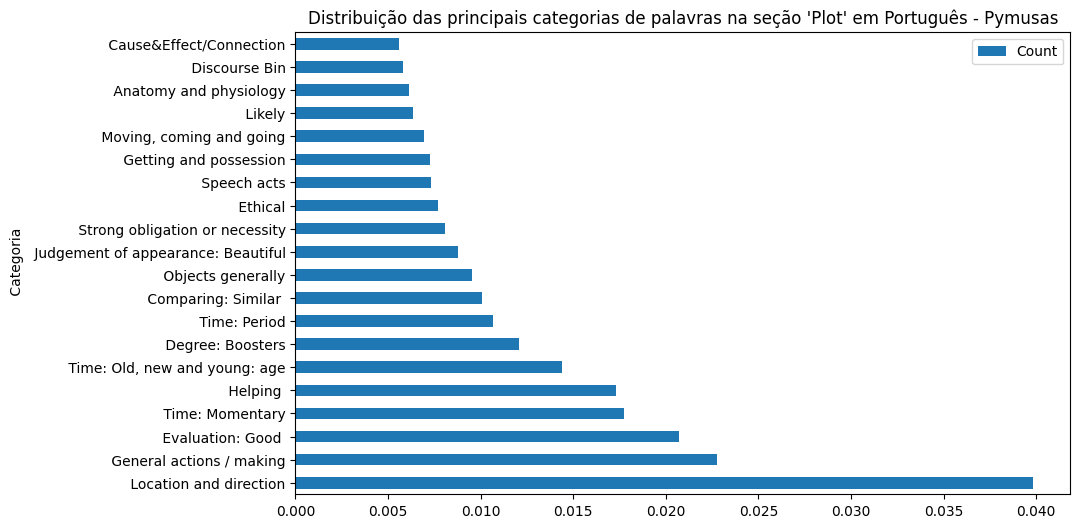

In [31]:
films = ["La La Land (film).txt", "The Wizard of Oz (1939).txt", "Titanic (filme de 1997).txt", "Titanic (filme de 1997).txt"]
df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras na seção 'Plot' em Português - Pymusas")
plt.yticks(fontsize=10)
plt.show()

In [32]:
path = './data/plots_en'
text = ""
list_files = os.listdir(path)
print(list_files)

['Peyton Place (film).txt', 'The Good Earth (film).txt', 'Crossfire (film).txt', 'Black Panther (film).txt', 'The Favourite.txt', 'Barry Lyndon.txt', 'Heaven Can Wait (1978 film).txt', 'Extremely Loud & Incredibly Close (film).txt', 'Boys Town (film).txt', 'Dunkirk (2017 film).txt', 'Three Billboards Outside Ebbing, Missouri.txt', 'The Bridge on the River Kwai.txt', 'America America.txt', 'Philomena (film).txt', 'Mutiny on the Bounty (1962 film).txt', 'Hacksaw Ridge.txt', 'Crash (2004 film).txt', 'Nicholas and Alexandra.txt', 'Jerry Maguire.txt', 'Bugsy.txt', 'Five Star Final.txt', 'The Accidental Tourist (film).txt', 'The Towering Inferno.txt', 'In Old Chicago.txt', 'Mr. Smith Goes to Washington.txt', 'Midnight Cowboy.txt', 'Marty (film).txt', 'Out of Africa (film).txt', 'The Godfather Part II.txt', 'Wuthering Heights (1939 film).txt', 'The Broadway Melody.txt', 'Spotlight (film).txt', 'Field of Dreams.txt', 'Witness (1985 film).txt', 'Seabiscuit (film).txt', 'Kramer vs. Kramer.txt', 

In [33]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_en(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [51]:
list_files = ['Barry Lyndon.txt', 'Nicholas and Alexandra.txt', 'Bugsy.txt', 'Out of Africa (film).txt', 'All This, and Heaven Too.txt', 'Elvis (2022 film).txt', 'The Cider House Rules (film).txt', 'Judgment at Nuremberg.txt', 'Lincoln (film).txt', 'The Snake Pit.txt', 'Argo (2012 film).txt', 'Captains Courageous (1937 film).txt', 'Munich (2005 film).txt', 'Cimarron (1931 film).txt', 'Watch on the Rhine.txt', 'Bridge of Spies (film).txt', 'The Social Network.txt', 'Elizabeth (film).txt', 'The Guns of Navarone (film).txt', 'Julia (1977 film).txt', 'American Hustle.txt', 'The Insider (film).txt', 'Tár.txt', 'The Philadelphia Story (film).txt', 'Darkest Hour (film).txt', 'Lawrence of Arabia (film).txt', 'Citizen Kane.txt', 'Gangs of New York.txt', 'JFK (film).txt', "The Nun's Story (film).txt", 'Sayonara.txt', 'Four Weddings and a Funeral.txt', 'The Irishman.txt', 'The Remains of the Day (film).txt', "All the President's Men (film).txt", 'Naughty Marietta (film).txt', '12 Years a Slave (film).txt', 'Henry V (1944 film).txt', 'Nixon (film).txt', 'Born on the Fourth of July (film).txt', 'The Pianist (2002 film).txt', 'The Lord of the Rings: The Two Towers.txt', 'Captain Blood (1935 film).txt', 'The Sand Pebbles (film).txt', "The King's Speech.txt", 'The Wolf of Wall Street (2013 film).txt', 'Inglourious Basterds.txt', 'Star Wars (film).txt', 'Gladiator (2000 film).txt', 'Milk (2008 American film).txt', 'Gandhi (film).txt', 'Viva Villa!.txt', 'The Thin Red Line (1998 film).txt', 'The Emigrants (film).txt', 'All Quiet on the Western Front (2022 film).txt', 'The Lord of the Rings: The Fellowship of the Ring.txt', 'Fiddler on the Roof (film).txt', "The Razor's Edge (1946 film).txt", 'Gone with the Wind (film).txt', 'Lost Horizon (1937 film).txt', 'Shanghai Express (film).txt', 'The Longest Day (film).txt', 'War Horse (film).txt', 'Arrowsmith (film).txt', 'Cleopatra (1963 film).txt', 'Around the World in 80 Days (1956 film).txt', 'Braveheart.txt', 'Top Hat.txt', 'Howards End (film).txt', 'The Robe (film).txt', 'The Imitation Game.txt', 'The Life of Emile Zola.txt', 'Lady for a Day.txt', 'Ford v Ferrari.txt', 'One Hour with You.txt', 'Patton (film).txt', 'Little Women (1933 film).txt']
results = []
for file in list_files:
    name = file.split(".txt")
    #classif = movies_classification["MOVIE THAT ADDRESSES SOCIAL TOPICS"]
    # print(name[0].upper())
    i = 0
    #if name[0].upper() in plots["TITLE_EN"].str.upper().values:
    i += 1
    #print(name[0])
    article = open(path + "/" + file, 'r')
    content = article.read()
    result = process_text(content)
    results.append(result)
len(results)
# print(i)

77

In [102]:
dict_categ = {}
for result in results[0]:
    if result['POS'] not in dict_categ.keys():
        dict_categ[result['POS']] = 1
    else:
        dict_categ[result['POS']] += 1

print(dict_categ)

{'PROPN': 69, 'PUNCT': 88, 'NUM': 4, 'NOUN': 115, 'SPACE': 8, 'ADP': 77, 'DET': 38, 'ADJ': 32, 'AUX': 34, 'VERB': 96, 'PRON': 76, 'CCONJ': 28, 'PART': 29, 'ADV': 22, 'SCONJ': 19}


In [ ]:
df = pd.DataFrame({
    "Categoria": dict_categ.keys(),
    "Frequencia": dict_categ.values()
}) 
df = df.sort_values('Frequencia', ascending=False)
df["Frequencia"] = df["Frequencia"] / df["Frequencia"].sum()
df

In [ ]:
df.plot(x="Categoria", y=["Frequencia"], kind='bar', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Inglês - Pymusas")
plt.show()

In [57]:
df = pd.DataFrame({
    "Categoria": dict_categ.keys(),
    "Frequencia": dict_categ.values()
}) 
df = df.sort_values('Frequencia', ascending=False)
df["Frequencia"] = df["Frequencia"] / df["Frequencia"].sum()
df

,Categoria,Frequencia
1,Z5,0.180428
16,Z99,0.125382
13,PUNCT,0.082569
22,Z8,0.036697
2,N1,0.024465
...,...,...
60,X6+,0.003058
12,G1.2/Q2.2,0.003058
58,G2.1@,0.003058
57,G1.1@,0.003058


In [52]:
df = pd.read_csv("pymusas_dict.csv", sep=";")
df["Count"] = [0 for i in range(len(df))]
df.set_index('Tag', inplace=True)
df

,Categoria,Count
Tag,,
A1,General And Abstract Terms,0
A1.1.1,General actions / making,0
A1.1.1-,Inaction,0
A1.1.2,Damaging and destroying,0
A1.1.2-,Fixing and mending,0
...,...,...
Z7,If,0
Z7-,Unconditional,0
Z8,Pronouns,0


In [53]:
for result in results:
    for sub_result in result:
        for tag in sub_result['USAS Tags']:
            if tag == "A5.4+":
                continue
            if tag in df.index:
                df.at[tag, 'Count'] += 1

df["Count"] = df["Count"] / df["Count"].sum()
df = df.reset_index()
for index, row in df.iterrows():
    if row["Count"] == 0:
        df = df.drop(index)
df = df.sort_values(by="Count", ascending=False)
df

,Tag,Categoria,Count
446,Z5,Grammatical bin,0.254949
452,Z99,Unmatched,0.046001
443,Z2,Geographical names,0.035837
361,T1.3,Time: Period,0.029746
1,A1.1.1,General actions / making,0.023538
...,...,...,...
345,S7.3-,No competition,0.000017
226,N3.5-,Weight: Light,0.000017
12,A1.4+,Lucky,0.000017
329,S4-,No kin,0.000017


In [54]:
df_aux = df.drop([446, 452, 450, 24, 211, 35, 36, 235])
# df_aux = df.drop([446, 246, 452, 36])
df_aux

,Tag,Categoria,Count
443,Z2,Geographical names,0.035837
361,T1.3,Time: Period,0.029746
1,A1.1.1,General actions / making,0.023538
202,M1,"Moving, coming and going",0.016768
32,A2.2,Cause&Effect/Connection,0.015990
...,...,...,...
345,S7.3-,No competition,0.000017
226,N3.5-,Weight: Light,0.000017
12,A1.4+,Lucky,0.000017
329,S4-,No kin,0.000017


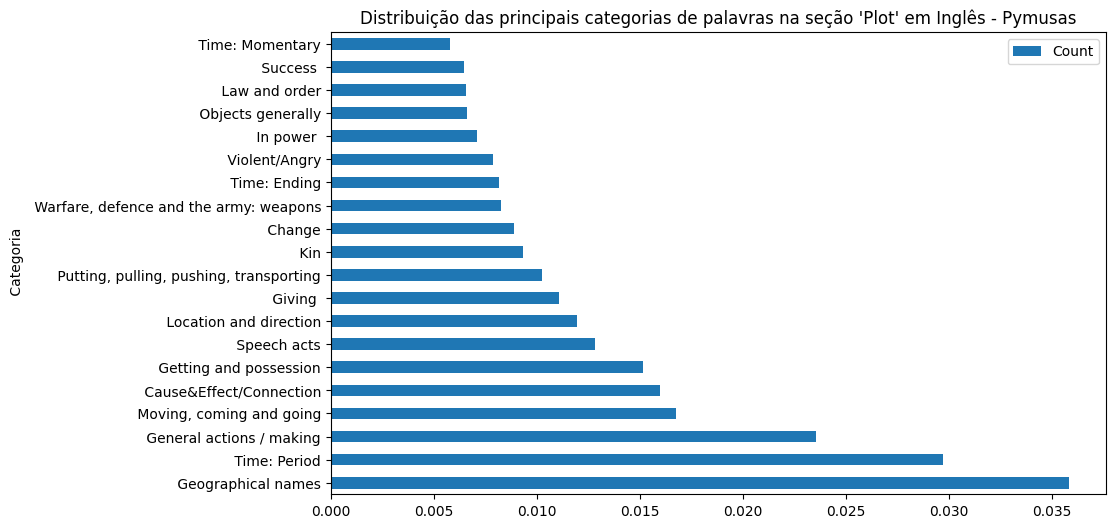

In [55]:
df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras na seção 'Plot' em Inglês - Pymusas")
plt.yticks(fontsize=10)
plt.show()

In [56]:
path = './data/plots_es'
text = ""
list_files = os.listdir(path)
print(list_files)

['Los emigrantes.txt', 'La canción de Bernadette.txt', 'El halcón maltés (película de 1941).txt', 'Atonement (película).txt', 'Picnic (película).txt', 'Barry Lyndon.txt', 'La forma del agua.txt', 'Espejismo de amor.txt', 'Fuego en la nieve (película).txt', 'Hugo (película).txt', 'Three Billboards Outside Ebbing, Missouri.txt', 'Cat on a Hot Tin Roof (película).txt', 'Gladiator.txt', 'The Reader.txt', 'El cielo y tú.txt', 'América, América (película).txt', 'Fugitivos (película de 1958).txt', 'Jerry Maguire.txt', 'Sense and Sensibility (película).txt', 'El orgullo de los Yanquis.txt', 'El séptimo cielo (película).txt', 'El Señor de los Anillos: el retorno del Rey.txt', 'War Horse.txt', 'The Towering Inferno.txt', 'In Old Chicago.txt', 'Mr. Smith Goes to Washington.txt', 'Midnight Cowboy.txt', 'La fuerza del cariño.txt', 'Zorba, el griego (película).txt', 'Pasaje a la India.txt', 'The Magnificent Ambersons.txt', 'Minari.txt', 'Dunkerque (película).txt', 'Hello, Dolly! (película).txt', 'Of

In [57]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_es(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [75]:
list_files = ['Los emigrantes.txt', 'El halcón maltés (película de 1941).txt', 'Picnic (película).txt', 'El cielo y tú.txt', 'El orgullo de los Yanquis.txt', 'El séptimo cielo (película).txt', 'La fuerza del cariño.txt', 'The Magnificent Ambersons.txt', 'Kramer vs. Kramer.txt', 'Gigi.txt', 'Philomena.txt', 'On Golden Pond.txt', 'Desde que te fuiste.txt', "Winter's Bone.txt", 'El príncipe de las mareas.txt', 'A Serious Man.txt', 'Sounder (película de 1972).txt', 'Rain Man.txt', 'Peyton Place (película de 1957).txt', 'Out of Africa.txt', 'Mildred Pierce.txt', 'Nacida ayer (película de 1950).txt', 'Suspicion.txt', 'Carta a tres esposas.txt', 'Marty.txt', 'La vida privada de Enrique VIII.txt', 'El discurso del rey.txt', 'Ellas hablan.txt', 'El violinista en el tejado (película).txt', 'Mi pie izquierdo.txt', 'Tár.txt', 'El lobo de Wall Street.txt', 'Ben-Hur (película de 1959).txt', 'Broadway Melody of 1936.txt', 'American Beauty.txt', 'Citizen Kane.txt', 'Los mejores años de nuestra vida.txt', 'Buenas noches, y buena suerte.txt', 'The Kids Are All Right.txt', 'Sed de escándalo (película de 1931).txt', 'Hamlet (película de 1948).txt', 'Ivanhoe (película de 1952).txt', 'All That Jazz (película).txt', 'The Fighter.txt', 'Reencuentro (película).txt', 'Historia de un matrimonio.txt', 'The Turning Point.txt', 'Little Women (película de 1933).txt', 'Chocolat (película de 2000).txt', 'Yanqui Dandy.txt', 'Mi vida es mi vida.txt', 'The Banshees of Inisherin.txt', 'Love Story (película).txt', 'Desaparecido (película).txt', 'David Copperfield (película de 1935).txt', 'Extremely Loud and Incredibly Close (película).txt', 'Ray (película).txt', 'Imitación de la vida.txt', 'Beasts of the Southern Wild.txt', 'Las horas.txt', 'Libeled Lady.txt', 'Un tranvía llamado Deseo (película de 1951).txt', 'Nido de víboras.txt', 'All About Eve.txt', 'Skippy.txt', 'It Happened One Night.txt', 'Viva Villa!.txt', 'La carta (película de 1940).txt', 'El color púrpura.txt', 'Shine (película).txt', 'La divorciada.txt', 'El golpe (película de 1973).txt', "The Bishop's Wife.txt", 'Vidas truncadas (película).txt', 'Mujercitas (película de 2019).txt', 'Las minas del rey Salomón (película de 1950).txt', 'El padre de la novia (película de 1950).txt', 'The Life of Emile Zola.txt', 'Piloto de pruebas (película de 1938).txt', 'La loba (película de 1941).txt', 'Atracción fatal.txt', 'El patriota (película de 1928).txt']
results = []
for file in list_files:
    name = file.split(".txt")
    #if name[0] in plots["TITLE_ES"].values:
    article = open(path + "/" + file, 'r')
    content = article.read()
    result = process_text(content)
    results.append(result)
#results

In [76]:
df = pd.read_csv("pymusas_dict.csv", sep=";")
df["Count"] = [0 for i in range(len(df))]
df.set_index('Tag', inplace=True)
df

,Categoria,Count
Tag,,
A1,General And Abstract Terms,0
A1.1.1,General actions / making,0
A1.1.1-,Inaction,0
A1.1.2,Damaging and destroying,0
A1.1.2-,Fixing and mending,0
...,...,...
Z7,If,0
Z7-,Unconditional,0
Z8,Pronouns,0


In [77]:
for result in results:
    for sub_result in result:
        for tag in sub_result['USAS Tags']:
            if tag in df.index:
                df.at[tag, 'Count'] += 1

df["Count"] = df["Count"] / df["Count"].sum()
df = df.reset_index()
for index, row in df.iterrows():
    if row["Count"] == 0:
        df = df.drop(index)
df = df.sort_values(by="Count", ascending=False)
df

,Tag,Categoria,Count
446,Z5,Grammatical bin,0.251081
452,Z99,Unmatched,0.131226
450,Z8,Pronouns,0.041244
72,A9+,Getting and possession,0.025076
211,N1,Numbers,0.020493
...,...,...,...
51,A5.3,Evaluation: Accuracy,0.000021
313,S1.2.5-,Weak,0.000021
310,S1.2.4-,Impolite,0.000021
417,X5.1-,Inattentive,0.000021


In [78]:
df_aux = df.drop([446, 452, 450, 24, 211, 35, 36, 235, 213])
df_aux.head(20)

,Tag,Categoria,Count
72,A9+,Getting and possession,0.025076
202,M1,"Moving, coming and going",0.014797
355,T1.1,Time: General,0.012549
1,A1.1.1,General actions / making,0.010964
208,M6,Location and direction,0.010686
267,P1,Education in general,0.010600
32,A2.2,Cause&Effect/Connection,0.010279
39,A4.1,"Generally kinds, groups, examples",0.008330
336,S7,Power relationship,0.008223
71,A9,Getting and giving: possession,0.008095


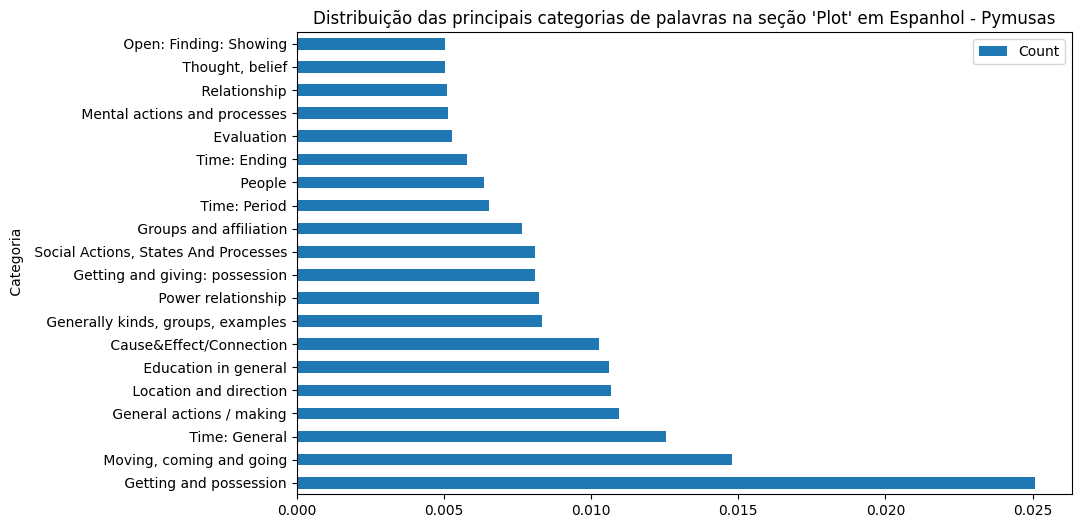

In [79]:
df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras na seção 'Plot' em Espanhol - Pymusas")
plt.yticks(fontsize=10)
plt.show()

Executando para filmes individuais

In [35]:
def process_text(text):
    output_doc = nlp_es(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

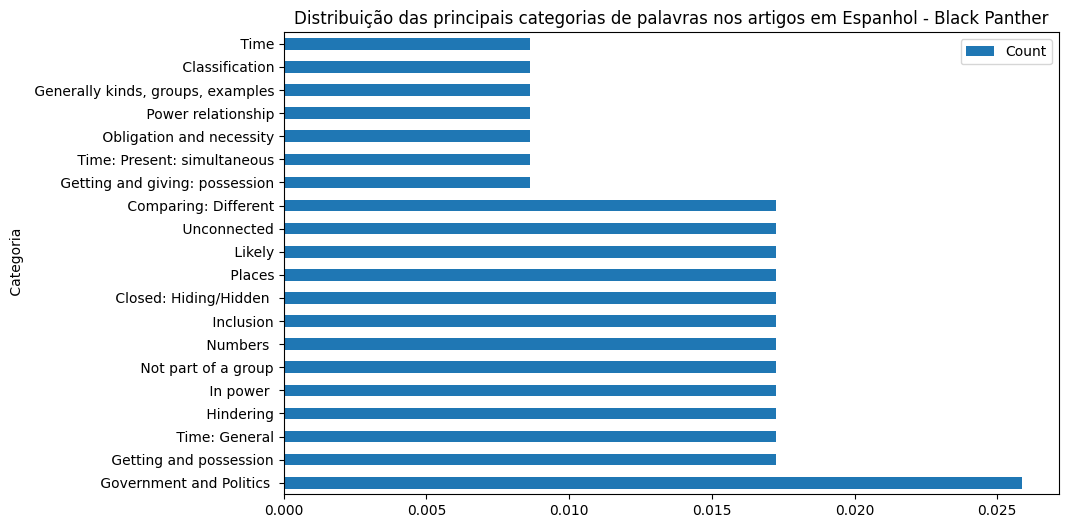

In [86]:
#list_files = ["La La Land (película).txt", "El mago de Oz.txt", "The Sound of Music.txt"]
list_files = ["E.T., el extraterrestre.txt", "Star Wars: Episodio IV - Una nueva esperanza.txt", "Black Panther (película).txt"]
#list_files = ["Everything Everywhere All at Once.txt", "Star Wars: Episódio IV – Uma Nova Esperança.txt", "Black Panther (filme).txt"]
article = open("./data/plots_es/Black Panther (película).txt", 'r')
content = article.read()
result = process_text(content)

df_test = pd.read_csv("pymusas_dict.csv", sep=";")
df_test["Count"] = [0 for i in range(len(df_test))]
df_test.set_index('Tag', inplace=True)

for sub_result in result:
    for tag in sub_result['USAS Tags']:
        if tag == 'A5.4+':
            break
        if tag in df_test.index:
            df_test.at[tag, 'Count'] += 1

df_test["Count"] = df_test["Count"] / df_test["Count"].sum()

df_test.to_csv("teste_df.csv", sep=';', index=True)

df_test = df_test.reset_index()
for index, row in df_test.iterrows():
    if row["Count"] == 0:
        df_test = df_test.drop(index)
df_test = df_test.sort_values(by="Count", ascending=False)


df_aux = df_test.drop([446, 452, 450])

df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Espanhol - Black Panther")
plt.yticks(fontsize=10)
plt.show()

In [9]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_en(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [5]:
film_names_en = []
film_names_es = []
film_names_pt = []

list_direc_en = os.listdir("./data/plots_en/")
list_direc_es = os.listdir("./data/plots_es/")
list_direc_pt = os.listdir("./data/plots_pt/")

for movie in sorted(list_direc_en):
    movie = movie.split(".txt")[0]
    film_names_en.append(movie)

for movie in sorted(list_direc_es):
    movie = movie.split(".txt")[0]
    film_names_es.append(movie)

for movie in sorted(list_direc_pt):
    movie = movie.split(".txt")[0]
    film_names_pt.append(movie)


In [33]:
movies_classification = {
    "Movie that makes social critics": [
        "12 Angry Men (1957 film)", 
        "A Clockwork Orange (film)", 
        "American Beauty (1999 film)", 
        "Get Out", 
        "Crash (2004 film)", 
        "Good Night, and Good Luck", 
        "Network (1976 film)", 
        "The Great Dictator", 
        "The Social Network",
        "Room (2015 film)", 
        "The Revenant (2015 film)",
        "Green Book (film)", 
        "Everything Everywhere All at Once",
        "Don't Look Up",
        "Joker (2019 film)"
    ],
    "Fantasy and Imaginary worlds": [
        "Avatar (2009 film)", 
        "Avatar: The Way of Water", 
        "District 9", 
        "E.T. the Extra-Terrestrial", 
        "Inception", 
        "The Shape of Water", 
        "The Wizard of Oz",
        "Star Wars (film)",
        "The Lord of the Rings: The Fellowship of the Ring", 
        "The Lord of the Rings: The Return of the King", 
        "The Lord of the Rings: The Two Towers"
    ],
    "Movies about historical events or people or War and Fights": [
        "12 Years a Slave (film)", 
        "1917 (2019 film)", 
        "A Man for All Seasons (1966 film)", 
        "A Farewell to Arms (1932 film)", 
        "All the President's Men (film)", 
        "Argo (2012 film)", 
        "Apollo 13 (film)", 
        "Gandhi (film)", 
        "Schindler's List", 
        "Lincoln (film)", 
        "The King's Speech", 
        "The Pianist (2002 film)", 
        "The Last Emperor",
        "Ben-Hur (1959 film)",
        "The Queen (2006 film)", 
        "Cleopatra (1963 film)",
        "Life Is Beautiful",
        "Saving Private Ryan",
        "Ford v Ferrari", 
        "Elvis (2022 film)",
        "The Imitation Game",
        "Inglourious Basterds", 
        "Gladiator (2000 film)",
        "Dunkirk (2017 film)", 
        "Darkest Hour (film)",
        "Bohemian Rhapsody (film)",
        "All Quiet on the Western Front (1930 film)",
        "All Quiet on the Western Front (2022 film)"
    ],
    "Musicals or Comedies or Love": [
        "42nd Street (film)", 
        "An American in Paris (film)", 
        "Anchors Aweigh (film)", 
        "Annie Hall", 
        "Chicago (2002 film)", 
        "Funny Girl (film)", 
        "La La Land", 
        "Mary Poppins (film)", 
        "Moulin Rouge!", 
        "Seven Brides for Seven Brothers", 
        "The Sound of Music (film)", 
        "Top Hat",
        "Beauty and the Beast (1991 film)",
        "Roman Holiday", 
        "Titanic (1997 film)",
        "A Star Is Born (1937 film)", 
        "A Star Is Born (2018 film)"
    ],
    "Movies about life's occurrences": [
        "127 Hours", 
        "A Beautiful Mind (film)", 
        "Boyhood (2014 film)", 
        "Driving Miss Daisy", 
        "Fargo (1996 film)", 
        "Good Will Hunting", 
        "Juno (film)", 
        "Marriage Story", 
        "Ordinary People", 
        "Terms of Endearment",
        "Little Women (1933 film)", 
        "Little Women (2019 film)",
        "Forrest Gump",
        "Once Upon a Time in Hollywood",
        "Midnight in Paris",
        "Gone with the Wind (film)"
    ],
    "Adventure": [
        "Around the World in 80 Days (1956 film)", 
        "Braveheart", 
        "Indiana Jones: Raiders of the Lost Ark", 
        "Life of Pi (film)", 
        "Mad Max: Fury Road", 
        "The Adventures of Robin Hood",
        "Top Gun: Maverick",
        "The Martian (film)"
    ],
    "Power relations": [
        "A Few Good Men", 
        "All the King's Men (1949 film)", 
        "Amadeus (film)", 
        "Dangerous Liaisons", 
        "Doctor Zhivago (film)", 
        "Frost_Nixon (film)", 
        "Henry V (1944 film)", 
        "JFK (film)", 
        "The Godfather", 
        "The Godfather Part II", 
        "The Godfather Part III", 
        "The Wolf of Wall Street (2013 film)"
    ],
    "Others": [
        "49th Parallel (film)", 
        "7th Heaven (1927 film)", 
        "A Room with a View (1985 film)",  
        "A Streetcar Named Desire (1951 film)", 
        "Alice Adams (1935 film)", 
        "All This, and Heaven Too", 
        "Atlantic City (1980 film)", 
        "Babe (film)", 
        "Barry Lyndon",  
        "Birdman (film)", 
        "Black Swan (film)", 
        "Bonnie and Clyde (film)", 
        "Broadcast News (film)", 
        "Cabaret (1972 film)", 
        "Capote (film)", 
        "Casablanca (film)", 
        "Cat on a Hot Tin Roof (1958 film)", 
        "Cavalcade (1933 film)", 
        "Chariots of Fire", 
        "Chinatown (1974 film)", 
        "Citizen Kane", 
        "Coal Miner's Daughter (film)", 
        "Coming Home (1978 film)", 
        "Cries and Whispers", 
        "Crossfire (film)", 
        "Crouching Tiger, Hidden Dragon", 
        "Dances with Wolves", 
        "Dark Victory", 
        "Dead End (1937 film)", 
        "Decision Before Dawn", 
        "Deliverance", 
        "Disraeli (1929 film)", 
        "Doctor Dolittle (1967 film)", 
        "Dodsworth (film)", 
        "Dog Day Afternoon", 
        "Double Indemnity", 
        "Dr. Strangelove", 
        "East Lynne (1931 film)", 
        "Elizabeth (film)", 
        "Erin Brockovich (film)", 
        "Extremely Loud & Incredibly Close (film)", 
        "Fanny (1961 film)", 
        "Fatal Attraction", 
        "Father of the Bride (1950 film)", 
        "Fiddler on the Roof (film)", 
        "Field of Dreams", 
        "Finding Neverland (film)", 
        "Five Easy Pieces", 
        "Five Star Final", 
        "Flirtation Walk", 
        "For Whom the Bell Tolls (film)", 
        "Foreign Correspondent (film)", 
        "Four Weddings and a Funeral", 
        "Friendly Persuasion (1956 film)", 
        "From Here to Eternity", 
        "Funny Girl (film)", 
        "Gangs of New York", 
        "Gaslight (1944 film)", 
        "Gentleman's Agreement", 
        "Giant (1956 film)", 
        "Gigi (1958 film)",  
        "Going My Way", 
        "Gosford Park", 
        "Grand Hotel (1932 film)", 
        "Gravity (2013 film)", 
        "Guess Who's Coming to Dinner", 
        "Hacksaw Ridge", 
        "Hamlet (1948 film)", 
        "Heaven Can Wait (1943 film)", 
        "Heaven Can Wait (1978 film)", 
        "Here Comes Mr. Jordan", 
        "Hold Back the Dawn", 
        "How Green Was My Valley (film)", 
        "How the West Was Won (film)", 
        "Howards End (film)", 
        "Hugo (film)", 
        "I Am a Fugitive from a Chain Gang", 
        "Imitation of Life (1934 film)", 
        "In Old Chicago", 
        "In Which We Serve", 
        "In the Bedroom", 
        "In the Heat of the Night (film)", 
        "In the Name of the Father (film)", 
        "It Happened One Night", 
        "It's a Wonderful Life", 
        "Ivanhoe (1952 film)", 
        "Jaws (film)", 
        "Jerry Maguire", 
        "Jezebel (1938 film)", 
        "Johnny Belinda (1948 film)", 
        "Judgment at Nuremberg", 
        "Julia (1977 film)", 
        "King Solomon's Mines (1950 film)", 
        "Kings Row", 
        "Kiss of the Spider Woman (film)", 
        "Kitty Foyle (film)", 
        "Kramer vs. Kramer", 
        "L.A. Confidential (film)", 
        "La Grande Illusion", 
        "Lady for a Day", 
        "Lawrence of Arabia (film)", 
        "Lenny (film)", 
        "Les Misérables (2012 film)", 
        "Libeled Lady",  
        "Lilies of the Field (1963 film)", 
        "Little Miss Sunshine", 
        "Lost Horizon (1937 film)", 
        "Lost in Translation (film)", 
        "Love Affair (1939 film)", 
        "Love Story (1970 film)", 
        "M*A*S*H (film)", 
        "Manchester by the Sea (film)", 
        "Mank", 
        "Marty (film)", 
        "Master and Commander: The Far Side of the World", 
        "Michael Clayton", 
        "Midnight Cowboy", 
        "Mildred Pierce (film)", 
        "Min and Bill", 
        "Mister Roberts (1955 film)", 
        "Moonlight (2016 film)", 
        "Mrs. Miniver", 
        "Mutiny on the Bounty (1935 film)", 
        "My Fair Lady (film)", 
        "My Left Foot", 
        "Mystic River (film)", 
        "Nashville (film)", 
        "No Country for Old Men (film)", 
        "No Way Out (1950 film)", 
        "Norma Rae", 
        "Ninotchka", 
        "Nomadland (film)", 
        "Notorious (1946 film)", 
        "Now, Voyager", 
        "Of Mice and Men (1939 film)", 
        "On Golden Pond (1981 film)", 
        "On the Waterfront", 
        "One Flew Over the Cuckoo's Nest (film)", 
        "One Foot in Heaven", 
        "One Hour with You",
        "One Night of Love",
        "Out of Africa (film)", 
        "Patton (film)",
        "Pulp Fiction", 
        "Raging Bull", 
        "Rain Man", 
        "Rebecca (1940 film)", 
        "Reds (film)", 
        "Sense and Sensibility (film)", 
        "Sergeant York", 
        "Shakespeare in Love",
        "Silver Linings Playbook",
        "Smilin' Through (1932 film)",
        "Sounder (film)", 
        "Stage Door (film)", 
        "Suspicion (1941 film)", 
        "The Awful Truth", 
        "The Barretts of Wimpole Street (1934 film)", 
        "The Big Chill",
        "The Blind Side (film)", 
        "The Broadway Melody", 
        "The Cardinal (1963 film)", 
        "The Cider House Rules (film)", 
        "The Color Purple (film)", 
        "The Country Girl (1954 film)", 
        "The Crying Game", 
        "The Curious Case of Benjamin Button (film)", 
        "The Deer Hunter", 
        "The Defiant Ones", 
        "The Departed", 
        "The Descendants", 
        "The Diary of Anne Frank (1959 film)", 
        "The Emigrants (film)", 
        "The End of the Affair (1999 film)", 
        "The English Patient (film)", 
        "The Favourite", 
        "The Fighter", 
        "The French Connection (film)", 
        "The Fugitive (1993 film)", 
        "The Full Monty", 
        "The Goodbye Girl", 
        "The Grand Budapest Hotel", 
        "The Grapes of Wrath (film)", 
        "The Green Mile (film)", 
        "The Guns of Navarone (film)", 
        "The Heiress (film)", 
        "The Hours (film)", 
        "The Hurt Locker", 
        "The Hustler (film)",  
        "The Insider", 
        "The Irishman", 
        "The Killing Fields (film)", 
        "The Kids Are All Right (film)", 
        "The Last Picture Show", 
        "The Life of Emile Zola", 
        "The Lion in Winter (1968 film)", 
        "The Little Foxes (film)", 
        "The Lost Weekend", 
        "The Magnificent Ambersons (film)", 
        "The Maltese Falcon (1941 film)", 
        "The Matrix", 
        "The Mission (1986 film)", 
        "The More the Merrier", 
        "The Nun's Story", 
        "The Phantom of the Opera (2004 film)", 
        "The Pride of the Yankees", 
        "The Quiet Man", 
        "The Reader (2008 film)",  
        "The Right Stuff (film)", 
        "The Road to Perdition", 
        "The Rose Tattoo (film)", 
        "The Seventh Heaven", 
        "The Seventh Seal", 
        "The Sixth Sense", 
        "The Social Network", 
        "The Talk of the Town (1942 film)", 
        "The Ten Commandments (1956 film)", 
        "The Thin Man (film)", 
        "The Thin Red Line (1998 film)", 
        "The Third Man", 
        "The Towering Inferno", 
        "The Tree of Life (film)", 
        "The Turning Point (1977 film)", 
        "The Verdict", 
        "The Way We Were", 
        "The White Parade", 
        "The Whistleblower", 
        "The Wind and the Lion", 
        "The Yearling (1946 film)", 
        "There Will Be Blood", 
        "Three Coins in the Fountain (film)", 
        "Three Smart Girls", 
        "Three Times Three", 
        "To Kill a Mockingbird (film)", 
        "Tootsie", 
        "Touch of Evil", 
        "Tower Heist", 
        "Traffic (2000 film)", 
        "Triumph of the Will", 
        "Twelve O'Clock High", 
        "Two for the Seesaw", 
        "Unforgiven",
        "Victor/Victoria (1982 film)", 
        "Waking Ned",
        "West Side Story (2021 film)", 
        "West Side Story (film)", 
        "Whiplash (2014 film)", 
        "Who's Afraid of Virginia Woolf? (film)", 
        "Winter's Bone", 
        "Witness (1985 film)",
        "Wuthering Heights (1939 film)", 
    ]
}

s = 0
for key, value in movies_classification.items():
    for movie in value:
        if movie not in film_names_en:
            value.remove(movie)

    s += len(value)
s

321

In [64]:
plots = pd.read_csv("./data/oscar_full_plot.csv", sep=';')
plots.set_index("TITULO", inplace = True)

for movie in movies_classification["Movie that makes social critics"]:
    movie_name = plots.at[movie, "TITLE_ES"]
    print(movie_name)
    if movie_name in film_names_en:
        article = open("./data/plots_es/" + movie_name + ".txt", 'r')
        content = article.read()
        result = process_text(content)

        df_test = pd.read_csv("pymusas_dict.csv", sep=";")
        df_test["Count"] = [0 for i in range(len(df_test))]
        df_test.set_index('Tag', inplace=True)

        for sub_result in result:
            for tag in sub_result['USAS Tags']:
                if tag in df_test.index:
                    df_test.at[tag, 'Count'] += 1

df_test["Count"] = df_test["Count"] / df_test["Count"].sum()

df_test.to_csv("teste_df.csv", sep=';', index=True)

df_test = df_test.reset_index()
for index, row in df_test.iterrows():
    if row["Count"] == 0:
        df_test = df_test.drop(index)
df_test = df_test.sort_values(by="Count", ascending=False)

df_aux = df_test.drop([36, 55, 211, 446, 452, 450])
#print(df_aux.head(20))

df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Espanhol - Musicais, Comédias ou Romance")
plt.yticks(fontsize=10)
plt.show()

12 Angry Men (película de 1957)


KeyError: 'A Clockwork Orange (film)'

In [83]:
index_df = sorted(plots.index)

list_direc = os.listdir("./data/plots_en/")
list_movies = sorted(list_direc)

print(index_df)
dict_ = {}
for i in range(len(index_df)):
    if index_df[i].upper() == list_movies[i].split(".txt")[0].upper():
        dict_[list_movies[i].split(".txt")[0]] = index_df[i]
    else:
        if index_df[i].upper() in list_movies[i].split(".txt")[0].upper() or list_movies[i].split(".txt")[0].upper() in index_df[i].upper():
            dict_[list_movies[i].split(".txt")[0]] = index_df[i]
        else:
            print(list_movies[i].split(".txt")[0], index_df[i])
print(dict_)

['12 Angry Men (1957 film)', '12 Years a Slave (film)', '127 Hours', '1917 (2019 film)', '42nd Street (film)', '49th Parallel (film)', '7th Heaven (1927 film)', 'A BEAUTIFUL MIND (2001 film)', 'A CLOCKWORK ORANGE (1971 film)', 'A Farewell to Arms (1932 film)', 'A Few Good Men', 'A Letter to Three Wives', 'A Man for All Seasons (1966 film)', 'A PASSAGE TO INDIA (1984 film)', 'A PLACE IN THE SUN (film)', 'A Room with a View (1985 film)', 'A SERIOUS MAN (2009 film)', "A SOLDIER'S STORY (1984 film)", 'A Star Is Born (1937 film)', 'A Star Is Born (2018 film)', 'A Streetcar Named Desire (1951 film)', 'AIRPORT (1970 film)', 'ALL THAT JAZZ (1979 film)', "ALL THE PRESIDENT'S MEN (1976 film)", 'AMADEUS (1984 film)', 'AN EDUCATION (2009 film)', 'ANATOMY OF A MURDER (1959 film)', 'ANCHORS AWEIGH (film)', 'ANNIE HALL (1977 film)', 'APOCALYPSE NOW (1979 film)', 'ARGO (2012 film)', 'AROUND THE WORLD IN 80 DAYS (film)', 'AS GOOD AS IT GETS (1997 film)', 'AVATAR (2009 film)', 'AWAKENINGS (1990 film)', 